# Deep Unfolding
In this notebook we will compare the iterative soft thresholding algorithm (ISTA) to its deep unfolded version, coined learned ISTA (LISTA). LISTA is in fact the origin of deep unfolding methodology, proposed by Gregor and LeCun back in 2010, and has spurred a multitude of variants over the years. This notebook compares a basic implementation of it to the model-based ISTA, examining the ability of deep unfolding to increase the convergence rate of iterative optimizers.


In [32]:
import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data


from plots import plot_admm_vs_ladmm_reconstruction, plot_admm_vs_ladmm_convergence, plot_observation

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float64)

## Data
Next, we generate a data set $\mathcal{D}=\{(\boldsymbol{s}_t, \boldsymbol{x}_t)\}_{t=1}^{n_t}$, where each $\boldsymbol{s}_t$ has $m=200$ entries, out of which at most $k=4$ are non-zero, while $\boldsymbol{x}_t$ has $n=150$ entires and is obtained via
\begin{equation}
\boldsymbol{x}_t = \boldsymbol{H}\boldsymbol{s}_t + \boldsymbol{w}_t,
\end{equation}
with $\boldsymbol{w}_t$ being i.i.d. Gaussian noise.

To that aim, we generate a dedicated class inheriting Dataset to get the data samples, and to allow each tuple to be comprised of both $(\boldsymbol{s}_t, \boldsymbol{x}_t)$ as well as $\boldsymbol{H}$.

In [33]:
class SimulatedData(Data.Dataset):
    def __init__(self, x, H, s):
        self.x = x
        self.s = s
        self.H = H

    def __len__(self):
        return self.x.shape[1]

    def __getitem__(self, idx):
        x = self.x[:, idx]
        H = self.H
        s = self.s[:, idx]
        return x, H, s

The next function creates a dataset.

In [34]:
def create_data_set(H, n, m, k, N=1000, batch_size=512, snr=30, noise_dev=0.5):
    # Initialization

    x = torch.zeros(n, N)
    s = torch.zeros(m, N)
    # Create signals
    for i in range(N):
        # Create a sparsed signal s
        index_k = np.random.choice(m, k, replace=False)
        peaks = noise_dev * np.random.randn(k)

        s[index_k, i] = torch.from_numpy(peaks).to(s)

        # X = Hs+w
        x[:, i] = H @ s[:, i] + 0.01 * np.random.randn(n)

    simulated = SimulatedData(x=x, H=H, s=s)
    data_loader = Data.DataLoader(dataset=simulated, batch_size=batch_size, shuffle=True)
    return data_loader

Finally, we generate the data set

In [35]:
n, m, k = 150, 200, 4

# Measurement matrix
H = torch.randn(n, m)
H /= torch.norm(H, dim=0)

train_loader = create_data_set(H, n=n, m=m, k=k, N=1000)

test_loader = create_data_set(H, n=n, m=m, k=k, N=1000)

Let's see what the samples look like


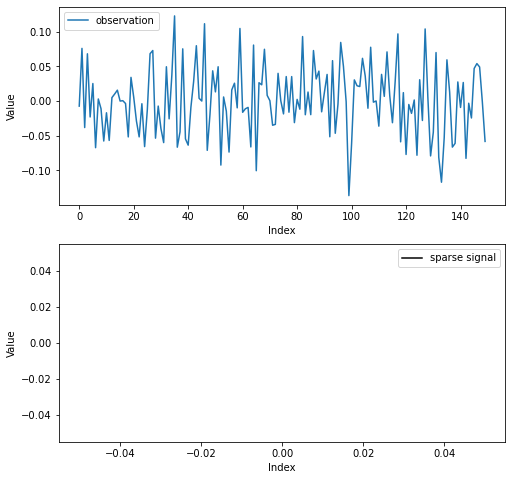

In [36]:
x_exm, _, s_exm =test_loader.dataset.__getitem__(5)
plot_observation(x_exm, s_exm)

Vanilla ADMM implementation

In [37]:
def vanilla_admm(x, H, lambda_=12.5, mu=0.00005, rho=0.01, max_itr=300, eps=10 ** -5):
    proj = torch.nn.Softshrink(rho / (2 * lambda_))

    # initial estimate
    s = torch.zeros((H.shape[1]))
    u = torch.zeros((H.shape[1]))
    v = torch.zeros((H.shape[1]))

    # left_term = (H^TH+2λI)^-1 2*lambda or rho?
    left_term = torch.linalg.inv(H.T @ H + rho * torch.eye(H.shape[1]))

    recovery_errors = []
    for k in range(max_itr):
        s_prev, v_prev, u_prev = s, v, u

        # Update s_k+1 = ((H^T)H+2λI)^−1(H^T x+2λ(vk−uk)).

        right_term = H.T @ x + rho * (v_prev - u_prev)
        s = left_term @ right_term

        # Update vk+1 = prox_(1/2λϕ)(sk+1 + uk)
        v = proj(s + u_prev)

        # Update uk+1 = uk + μ (sk+1 − vk+1).

        u = u_prev + mu * (s - v)

        # # cease if convergence achieved
        if torch.sum(torch.abs(s - s_prev)) <= eps:
            break

        # save recovery error
        recovery_errors.append(torch.sum((torch.matmul(H, s) - x) ** 2))

    return s

Model Based ADMM implementation

In [38]:
class LADMM_Model(nn.Module):
    def __init__(self, n, m, T=6, rho=0.01, H=None, lambda_=12.5, mu=0.00005):
        super(LADMM_Model, self).__init__()
        self.n, self.m = n, m
        self.H = H

        # ISTA Iterations
        self.T = T

        # Initialization
        self.rho = nn.Parameter(torch.ones(T + 1, 1, 1) * rho, requires_grad=True) # Lagrangian Multiplier
        self.lambda_ = nn.Parameter(torch.ones(T + 1, 1, 1) * lambda_, requires_grad=True)
        self.mu = nn.Parameter(torch.ones(T + 1, 1, 1) * mu, requires_grad=True)

    def _shrink(self, s, beta, rho):
        return beta * F.softshrink(s / beta, lambd=rho)

    def forward(self, x):
        """

        Args:
            x: a sparse signal observation
        Returns: S reconstruction
        """
        # H.shape[1] = 200, x.shape[0[ = 512 (batch size)
        # s_prev = torch.zeros(x.shape[0], self.H.shape[1])
        u_prev = torch.zeros((x.shape[0], self.H.shape[1]))
        v_prev = torch.zeros((x.shape[0], self.H.shape[1]))

        #################### Iteration 0 ####################

        #TODO NIR left_term = (H^TH+2λI)^-1 2*lambda or rho?
        left_term = torch.linalg.inv(self.H.T @ self.H + self.rho[0, :, :] * torch.eye(self.H.shape[1]))

        right_term = (self.H.T @ x.T).T + self.rho[0, :, :] * (v_prev - u_prev)

        s = (left_term @ right_term.T).T
        v = self._shrink(s + u_prev,
                         self.rho[0, :, :] / (2 * self.lambda_[0, :, :]),
                         rho=self.rho[0, :, :].item())
        u = u_prev + self.mu[0, :, :] * (s - v)

        #################### Iteration 1<=i<=K ####################

        for i in range(1, self.T + 1):
            s_prev, v_prev, u_prev = s, v, u

            # left_term = (H^TH+2λI)^-1 2*lambda or rho?
            left_term = torch.linalg.inv(self.H.T @ self.H + self.rho[i, :, :] * torch.eye(self.H.shape[1]))

            right_term = (self.H.T @ x.T).T + self.rho[i, :, :] * (v_prev - u_prev)

            # Update s_k+1 = ((H^T)H+2λI)^−1(H^T x+2λ(vk−uk)).
            s = (left_term @ right_term.T).T

            # Update vk+1 = prox_(1/2λϕ)(sk+1 + uk)
            v = self._shrink(s + u_prev, self.rho[i, :, :] / (2 * self.lambda_[i, :, :]), rho=self.rho[i, :, :].item())

            # Update uk+1 = uk + μ (sk+1 − vk+1).
            u = u_prev + self.mu[i, :, :] * (s - v)

        return s

## Train and Validation

For training, we use SGDM with learning rate scheduler and the $\ell_2$ loss

In [39]:
def train(model, train_loader, valid_loader, num_epochs=60):
    """Train a network.
    Returns:
        loss_test {numpy} -- loss function values on test set
    """
    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-05,
        momentum=0.9,
        weight_decay=0,
    )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(train_loader):
            s_hat = model(b_x)
            loss = F.mse_loss(s_hat, b_s, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()

        # Aggregate loss
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # Validation
        model.eval()
        test_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(valid_loader):
            s_hat = model(b_x)
            test_loss += F.mse_loss(s_hat, b_s, reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)

        if epoch % 10 == 0:
            print("Epoch %d, Train loss %.8f, Validation loss %.8f" % (epoch, loss_train[epoch], loss_test[epoch]))

    return loss_test, b_x, b_s

The following functions apply L-ADMM and ADMM for given data sets


In [40]:
def ladmm_apply(train_loader, test_loader, T, H):
    n = H.shape[1]
    m = H.shape[1]

    ladmm = LADMM_Model(n=n, m=m, T=T, H=H)

    loss_test, b_x, b_s = train(ladmm, train_loader, test_loader)
    err_list = loss_test[-1]

    return err_list, ladmm, b_x, b_s


def admm_apply(test_loader, T, H):

    loss = 0

    for step, (x, _, s) in enumerate(test_loader.dataset):
        s_hat = vanilla_admm(x=x, H=H, max_itr=T)
        loss += F.mse_loss(s_hat, s, reduction="sum").data.item()

    return loss / len(test_loader.dataset)

## Comparing L-ADMM to ADMM
Finally, we show that by learning the parameterization of ADMM in a per-iteration manner, one can notably imporve its convergence rate. To that aim, in the following loop we compare ISTA to trained LISTA with different number of iterations.

Epoch 0, Train loss 0.29832500, Validation loss 0.28738278
Epoch 10, Train loss 0.28893975, Validation loss 0.27772286
Epoch 20, Train loss 0.27139223, Validation loss 0.25888397
Epoch 30, Train loss 0.20756651, Validation loss 0.19165632
Epoch 40, Train loss 0.14136727, Validation loss 0.13124650
Epoch 50, Train loss 0.11259037, Validation loss 0.10577117


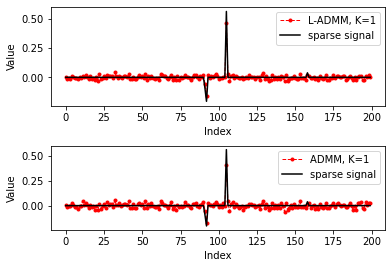

Epoch 0, Train loss 0.29970934, Validation loss 0.29009287
Epoch 10, Train loss 0.29477535, Validation loss 0.28365799
Epoch 20, Train loss 0.25576923, Validation loss 0.24049286
Epoch 30, Train loss 0.14434882, Validation loss 0.12623301
Epoch 40, Train loss 0.06156513, Validation loss 0.05420512
Epoch 50, Train loss 0.04395585, Validation loss 0.04005775


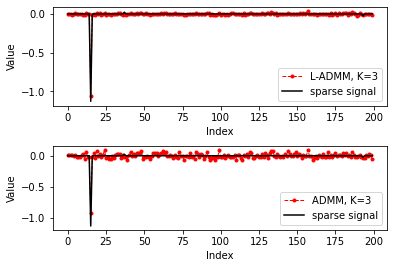

Epoch 0, Train loss 0.29970067, Validation loss 0.29009455
Epoch 10, Train loss 0.29901891, Validation loss 0.28927054
Epoch 20, Train loss 0.28983519, Validation loss 0.27826513
Epoch 30, Train loss 0.22150820, Validation loss 0.20262841
Epoch 40, Train loss 0.07746394, Validation loss 0.06389689
Epoch 50, Train loss 0.02953151, Validation loss 0.02599747


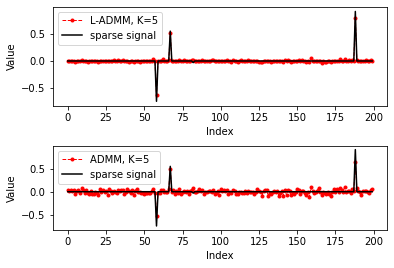

Epoch 0, Train loss 0.29964471, Validation loss 0.29003782
Epoch 10, Train loss 0.29888176, Validation loss 0.28913694
Epoch 20, Train loss 0.29209839, Validation loss 0.28122006
Epoch 30, Train loss 0.23814235, Validation loss 0.22035702
Epoch 40, Train loss 0.08429952, Validation loss 0.06866897
Epoch 50, Train loss 0.02287972, Validation loss 0.01980672


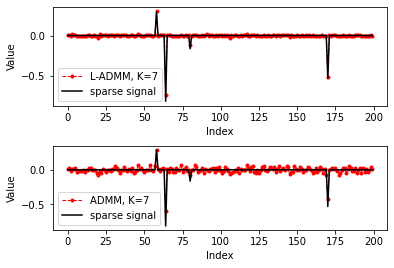

Epoch 0, Train loss 0.29958654, Validation loss 0.28997835
Epoch 10, Train loss 0.29863093, Validation loss 0.28885405
Epoch 20, Train loss 0.29091664, Validation loss 0.27997917
Epoch 30, Train loss 0.23635722, Validation loss 0.21855162
Epoch 40, Train loss 0.07978800, Validation loss 0.06448279
Epoch 50, Train loss 0.01895398, Validation loss 0.01633629


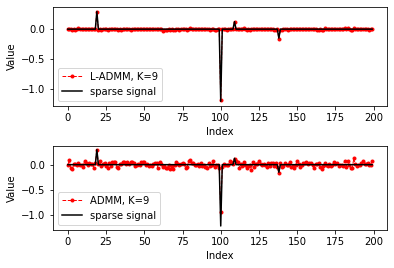

Epoch 0, Train loss 0.29952826, Validation loss 0.28991888
Epoch 10, Train loss 0.29836871, Validation loss 0.28855592
Epoch 20, Train loss 0.28927745, Validation loss 0.27816926
Epoch 30, Train loss 0.23048190, Validation loss 0.21254123
Epoch 40, Train loss 0.07395954, Validation loss 0.05963905
Epoch 50, Train loss 0.01690067, Validation loss 0.01462180


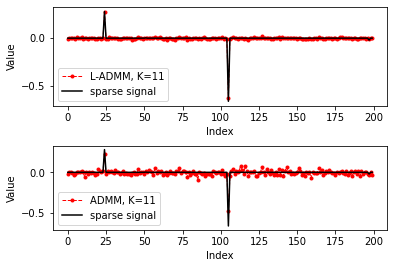

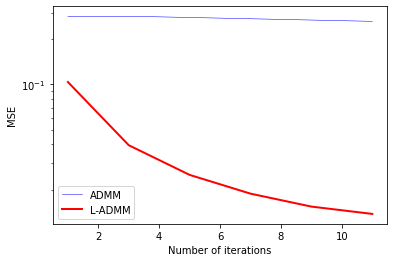

In [41]:

# Number of unfoldings
tstart, tend, tstep = 1, 13, 2
T_opt = range(tstart, tend, tstep)

admm_mse = []
ladmm_mse = []

for i, T in enumerate(T_opt):

    # Train and apply model based ADMM
    err_lst, k_l_admm, b_x, b_s = ladmm_apply(train_loader, test_loader, T, H)
    ladmm_mse.append(err_lst)

    # Apply vanilla ADMM
    admm_mse.append(admm_apply(test_loader, T, H))

    ######################### Visualization #########################

    # Visualize performance of a single signal from the validation batches b_x, b_s
    b_x, s_gt = b_x[0], b_s[0]

    s_hat_ladmm = k_l_admm(b_x)
    s_hat_ladmm = s_hat_ladmm.detach().numpy()[0]

    s_hat_admm = vanilla_admm(x=b_x, H=H, max_itr=T)

    plot_admm_vs_ladmm_reconstruction(s_hat_admm=s_hat_admm,
                                      s_hat_ladmm=s_hat_ladmm, T=k_l_admm.T, s_gt=s_gt)


plot_admm_vs_ladmm_convergence(T_opt,admm_mse, ladmm_mse)

